## read in data

In [1]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

prop = 'soc'
tgt = 'soc_log1p'
version = 'v20250301'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/data_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_parquet(f'./material/data_test_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any')

# train = train.loc[train['soc']<50]
# test = test.loc[test['soc']<50]

## train the model

In [2]:
# train the model
from trees_rf import cast_tree_rf
ttprint(f'start training')
model.fit(train[covs], train[tgt])
ttprint(f'finish training')
model = cast_tree_rf(model)

# variable importance
importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.to_csv(f'./metric/feature_importance_{version}.csv', index=False)


[13:39:57] start training
[13:40:02] finish training


## generate prediction

In [3]:
# tree predictions
tree_predictions = model.predict(test[covs])

# get point prediction
y_pred = np.mean(tree_predictions, axis=0)
y_pred = np.expm1(y_pred)
test['pred'] = y_pred

# uncertainty in std
tree_predictions = np.expm1(tree_predictions)
test['pred_std'] = np.std(tree_predictions, axis=0)


In [4]:
test.loc[test['lc_survey']=='bare land & lichens/moss','lc_survey'] = 'bareland'
test.loc[test['lc_survey']=='water areas & wetland','lc_survey'] = 'wetland'

## organize soc pairs

In [5]:
tcol = ['lat', 'lon', 'time', 'soc', 'pred','pred_std', 'lc_survey'] # time series cols
scol = ['id', 'ref', 'nuts0', 'hzn_dep']

data_list = []
ttprint('start organizing')
for iid in test['id'].unique():
    temp = test.loc[test['id'] == iid].sort_values(by=['time'])  

    static_vals = temp.iloc[0][scol].tolist()  # Extract static values once

    if len(temp) == 2:
        ts_vals = [temp[itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

    elif len(temp) > 2:
        # Case with 3 points: form 3 pairs
        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

pair = pd.DataFrame(data_list, columns=scol + [i + '_pair' for i in tcol])
ttprint('finish organizing')

# organize features
pair['year_change'] = pair['time_pair'].str[1] - pair['time_pair'].str[0]
pair['soc_change'] = pair['soc_pair'].str[1] - pair['soc_pair'].str[0]
pair['pred_change'] = pair['pred_pair'].str[1] - pair['pred_pair'].str[0]
pair['noise'] = np.sqrt(pair['pred_std_pair'].str[1]**2 + pair['pred_std_pair'].str[0]**2)
pair['snr'] = pair['soc_change'].abs()/pair['noise']
pair['soc_mean'] = (pair['soc_pair'].str[1] + pair['soc_pair'].str[0])/2

[13:40:02] start organizing
[13:40:07] finish organizing


## evaluate prediction accuracy for SOC change

/tmp/ipykernel_2436023/3856596338.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # More space at bottom for colorbars


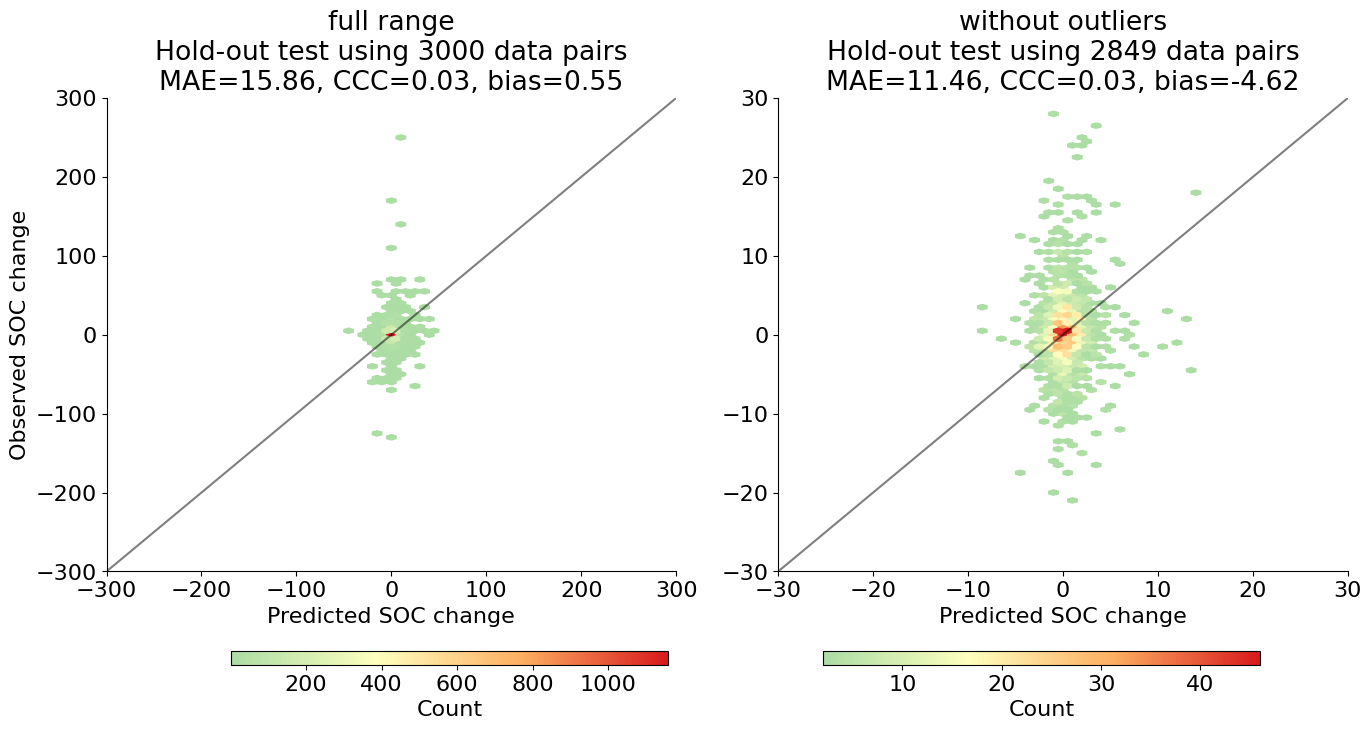

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from model_fit import calc_metrics
import math
import matplotlib.pyplot as plt

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

plt.rcParams.update({'font.size': 16})

show_ranges = [[-300, 300], [-30, 30]]
titles = ['full range', 'without outliers']

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)

for i, ax in enumerate(axes):
    show_range = show_ranges[i]

    if i == 0:
        y_t = pair['soc_change']
        y_p = pair['pred_change']
        rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
        metrics = (mae, ccc, bias)
        gs = (60,60)
    else:
        y_t = pair.loc[pair['soc_change'] < 30, 'soc_change']
        y_p = pair.loc[pair['soc_change'] < 30, 'pred_change']
        rmse_s, mae_s, medae_s, mape_s, ccc_s, r2_s, bias_s = calc_metrics(y_p, y_t, 'normal')
        metrics = (mae_s, ccc_s, bias_s)
        gs = (60,60)

    ax.set_title(f'{titles[i]}\nHold-out test using {len(y_t)} data pairs\nMAE={metrics[0]:.2f}, CCC={metrics[1]:.2f}, bias={metrics[2]:.2f}')
    
    hb = ax.hexbin(
        y_p, y_t,
        gridsize=gs,
        cmap=cet_l19_cmap,
        extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
        mincnt=2
    )

    ax.set_xlabel('Predicted SOC change')
    if i == 0:
        ax.set_ylabel('Observed SOC change')

    ax.plot(show_range, show_range, "-k", alpha=0.5)
    ax.set_xlim(show_range)
    ax.set_ylim(show_range)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cax = fig.add_axes([ax.get_position().x0+0.05, ax.get_position().y0 - 0.08, ax.get_position().width-0.04, 0.02])
    cb = fig.colorbar(hb, cax=cax, orientation='horizontal')
    cb.set_label('Count')

plt.tight_layout(rect=[0, 0.05, 1, 1])  # More space at bottom for colorbars
plt.savefig('./figure/plot_evaluation_pair.change.amount.pdf', bbox_inches='tight')
plt.show()


## change direction estimation

In [7]:
pair['direction_pred'] = ''
pair.loc[pair['pred_change']>=0, 'direction_pred'] = 'increase'
pair.loc[pair['pred_change']<0, 'direction_pred'] = 'decrease'

pair['direction_obsv'] = ''
pair.loc[pair['soc_change']>=0, 'direction_obsv'] = 'increase'
pair.loc[pair['soc_change']<0, 'direction_obsv'] = 'decrease'

In [8]:
from sklearn.metrics import f1_score, accuracy_score

y_true = pair['direction_obsv']
y_pred = pair['direction_pred']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, pos_label='increase')
print(f'accuracy: {accuracy}; f1: {f1}')

accuracy: 0.5266666666666666; f1: 0.5691747572815534


### This is only a bit better than random guess

## SNR of paired changes

In [9]:
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]


In [23]:
l1 = pair['lc_str'].unique().tolist()
l2 = [ii.replace('land','') for ii in l1]
map_l = dict(zip(l1,l2))

pair['lc_str'] = pair['lc_str'].map(map_l)


In [24]:
vc = pair['lc_survey_pair'].value_counts()
lcl = vc.index.tolist()

stable_lc = []
change_lc = []
for ii in lcl:
    if len(list(set(ii)))==1:
        stable_lc.append(ii)
    else:
        change_lc.append(ii)
        
pair['lc_change'] = ''
pair.loc[pair['lc_survey_pair'].isin(stable_lc),'lc_change'] = 0
pair.loc[pair['lc_survey_pair'].isin(change_lc),'lc_change'] = 1

pair['signal'] = pair['soc_change'].abs()

In [25]:
pair.groupby(['year_change'])['snr'].describe()

,count,mean,std,min,25%,50%,75%,max
year_change,,,,,,,,
3,1007.0,0.271913,0.386151,0.0,0.055902,0.145423,0.321913,4.845040
6,1000.0,0.311805,0.382375,0.0,0.072975,0.172481,0.389538,2.242478
9,993.0,0.297369,0.408299,0.0,0.056128,0.168308,0.375561,6.045054


In [26]:
pair.groupby(['lc_change'])['snr'].describe()

,count,mean,std,min,25%,50%,75%,max
lc_change,,,,,,,,
0,2536.0,0.297521,0.402015,0.0,0.061229,0.161367,0.372781,6.045054
1,464.0,0.272401,0.336163,0.0,0.058717,0.160702,0.321677,2.128192


In [27]:
vc = pair['lc_str'].value_counts()

lc_long = vc[vc>20].index.tolist()
pair.loc[pair['lc_str'].isin(lc_long)].groupby(['lc_str'])['snr'].describe()

,count,mean,std,min,25%,50%,75%,max
lc_str,,,,,,,,
bare-crop,38.0,0.208130,0.260466,0.006084,0.034561,0.095009,0.276330,0.931982
crop-bare,61.0,0.255495,0.296638,0.000000,0.068505,0.167035,0.313296,1.552056
crop-crop,1165.0,0.289355,0.394876,0.000000,0.066832,0.166688,0.355988,6.045054
crop-grass,107.0,0.267130,0.292511,0.005013,0.091550,0.168925,0.345198,2.076481
grass-crop,101.0,0.257285,0.313708,0.002972,0.065270,0.160834,0.304949,2.031302
grass-grass,509.0,0.297149,0.412276,0.000000,0.056059,0.149856,0.347450,3.079521
grass-wood,27.0,0.372797,0.560541,0.004358,0.054744,0.150148,0.353675,2.128192
shrub-shrub,37.0,0.346172,0.373220,0.004554,0.099208,0.206330,0.464530,1.594280
shrub-wood,21.0,0.305979,0.308784,0.000000,0.105030,0.226634,0.312103,1.122749


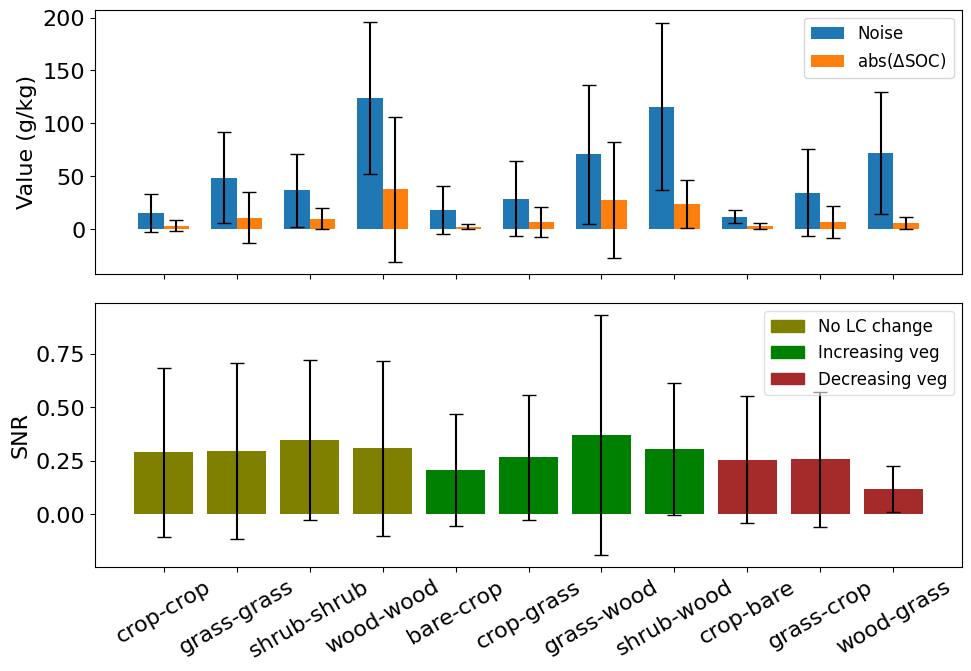

In [37]:
import matplotlib.patches as mpatches
lc_order = [
    'crop-crop', 'grass-grass', 'shrub-shrub', 'wood-wood',
    'bare-crop', 'crop-grass', 'grass-wood', 'shrub-wood', 
    'crop-bare', 'grass-crop', 'wood-grass'
]

lc_long = lc_order  
grouped_stats = pair.loc[pair['lc_str'].isin(lc_long)].groupby('lc_str')[['snr', 'noise', 'signal']].agg(['mean', 'std'])
grouped_stats.columns = ['_'.join(col) for col in grouped_stats.columns]
grouped_stats = grouped_stats.reset_index()

grouped_stats['lc_str'] = pd.Categorical(grouped_stats['lc_str'], categories=lc_order, ordered=True)
grouped_stats = grouped_stats.sort_values('lc_str')

x = np.arange(len(grouped_stats['lc_str']))
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

bar1 = ax1.bar(x - width/2, grouped_stats['noise_mean'], width, yerr=grouped_stats['noise_std'], capsize=5, label='Noise')
bar2 = ax1.bar(x + width/2, grouped_stats['signal_mean'], width, yerr=grouped_stats['signal_std'], capsize=5, label='abs($\Delta$SOC)')

ax1.set_ylabel('Value (g/kg)')
ax1.legend(fontsize=12)

colors = ['olive','olive','olive','olive','green','green','green','green','brown','brown','brown']
ax2.bar(x, grouped_stats['snr_mean'], yerr=grouped_stats['snr_std'], capsize=5, color=colors)
ax2.set_ylabel('SNR')

# Shared X-axis labels
ax2.set_xticks(x)
ax2.set_xticklabels(grouped_stats['lc_str'], rotation=30)

olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')
ax2.legend(handles=[olive_patch, green_patch, brown_patch],fontsize=12,framealpha=0.6)

plt.tight_layout()
plt.savefig('./figure/plot_pair_analysis.pdf', bbox_inches='tight')
plt.show()

In [42]:
coe = pair[['soc_mean','soc_change','signal','noise','snr']].corr()

In [43]:
coe

,soc_mean,soc_change,signal,noise,snr
soc_mean,1.000000,0.005331,0.599567,0.584660,0.222965
soc_change,0.005331,1.000000,0.106271,0.012847,0.114175
signal,0.599567,0.106271,1.000000,0.467388,0.541283
noise,0.584660,0.012847,0.467388,1.000000,-0.040203
snr,0.222965,0.114175,0.541283,-0.040203,1.000000


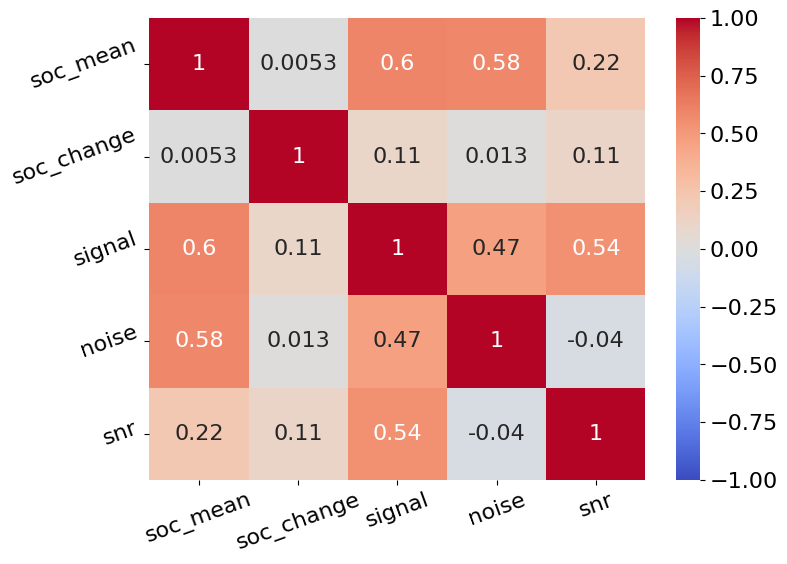

In [46]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=20)
plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()